# Introduction

This part of the demo shows a basic classification workflow: scaling the data, training the classifier and finally evaluating its performance. I'm using Dask for loading the data, distributing the computing across multiple processes and keeping memory usage under control. The Dask-ml library is an extra Dask library specifically for machine learning. It provides a few models like linear models, some preprocessing methods, incremental PCA, and distributed hyperparameter search (which is also memory efficient).

Each row has 55 values, 52 of which are features, and an associated fault number from 0 (no fault) to 20. The goal is to predict the fault number.

Scikit-learn provides the ML algorithms used in this demo, which Dask wraps with an incremental learning algorithm [dask_ml.wrappers.Incremental](https://ml.dask.org/modules/generated/dask_ml.wrappers.Incremental.html#dask_ml.wrappers.Incremental). This wrapper works with any class that implements the Sckit-learn `partial_fit` method, which is supported by several Scikit-learn classes in this [list of incremental learners](https://scikit-learn.org/stable/computing/scaling_strategies.html#incremental-learning). Dask-ml calls `partial_fit` for each block of the input data.

In [1]:
import os

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler # Scale and shift each feature to have zero mean and standard deviation equal to one.
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import IncrementalPCA

import datashader as ds
import dask
from dask.distributed import Client
from dask import dataframe as ddf
from dask import array as da
from dask_ml.wrappers import Incremental
from dask_ml.preprocessing import PolynomialFeatures
# from dask_ml.decomposition import PCA, IncrementalPCA

import hvplot.dask
import hvplot

import pandas as pd

In [2]:
hvplot.extension('bokeh')
hvplot.output(backend='bokeh')

## Configure paths

Dask has some difficulties when running in a remote Jupyter Lab instance (in 
this case a container).
For whatever reason, changing directory to the location of this workbook in the
container doesn't always make the Dask worker processes use the same directory.
Therefore, I'm setting the paths explicitly.

In [3]:
project_dir = '/opt/notebooks/Git/MachineLearningProjects/MLWithBigDataOnALaptop/src/dask'
dask_src_data_dir = os.path.join(project_dir, 'data')
train_data_path = os.path.join(dask_src_data_dir, 'train.hdf')
test_data_path = os.path.join(dask_src_data_dir, 'test.hdf')
dask_working_dir = os.path.join(project_dir, 'dask-worker-space')

# Creating the Dask cluster

This creates a local cluster with four worker processes, each with one thread and 1GiB of memory. You can use multiple threads per worker, which results in a degree of parallelism, mostly in loading the data. However, this allows more RAM per process, which is useful for large blocks of data.

Passing `memory_limit='1GiB'` limits the RAM per process to 1GiB. If more than about 60% of this is used, Dask will start spilling **some** memory to disk. Dask distinguishes between managed an unmanaged memory. Managed memory is Python objeects, unmanaged memory is held by external non-python libraries. Managed memory can be spilled to disk and gets stored in a folder called `dask-worker-space`.

In [4]:
dask_client = Client(n_workers=4, threads_per_worker=1, memory_limit='1GiB')

2025-01-12 18:47:10,620 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h0ath5da', purging
2025-01-12 18:47:10,721 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-830jwyyx', purging
2025-01-12 18:47:10,802 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-u12lqhf6', purging
2025-01-12 18:47:10,804 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xdfzf684', purging


In [5]:
# Give Dask's distributed scheduler the path to a directory that it can use for temporary storage.
dask.config.set({'temporary_directory': dask_working_dir})

# Prepare the data

## Loading the data

Here, Dask doesn't immediately load the HDF5 file, instead it creates a task graph. Assigning subsets of the data to `X_data` and `y_data` just adds to this task graph.

In [6]:
print(f'Working directory: {os.getcwd()}')
os.chdir(project_dir)
print(f'New working directory: {os.getcwd()}')

Working directory: /opt/notebooks/Git/MachineLearningProjects/MLWithBigDataOnALaptop/src/dask
New working directory: /opt/notebooks/Git/MachineLearningProjects/MLWithBigDataOnALaptop/src/dask


In [7]:
training_data = ddf.read_hdf(train_data_path, key='/train_*')

In [8]:
X_data = training_data.iloc[:, 3:]
y_data = training_data.faultNumber

## Exploratory data analysis

Before we start training any classifiers, let's plot the data to see if there's any obvious patterns. We'll also apply some dimensionality reduction algorithms to see if we can see any patterns. However, we'll only do that after the data has been scaled.

### Some basic checks first

First lets see if there's anything obviously wrong, e.g. missing values or ridiculously small or large values.

In [9]:
# Check for missing values in the training data.
X_data.isna().sum().compute()

xmeas_1     0
xmeas_2     0
xmeas_3     0
xmeas_4     0
xmeas_5     0
xmeas_6     0
xmeas_7     0
xmeas_8     0
xmeas_9     0
xmeas_10    0
xmeas_11    0
xmeas_12    0
xmeas_13    0
xmeas_14    0
xmeas_15    0
xmeas_16    0
xmeas_17    0
xmeas_18    0
xmeas_19    0
xmeas_20    0
xmeas_21    0
xmeas_22    0
xmeas_23    0
xmeas_24    0
xmeas_25    0
xmeas_26    0
xmeas_27    0
xmeas_28    0
xmeas_29    0
xmeas_30    0
xmeas_31    0
xmeas_32    0
xmeas_33    0
xmeas_34    0
xmeas_35    0
xmeas_36    0
xmeas_37    0
xmeas_38    0
xmeas_39    0
xmeas_40    0
xmeas_41    0
xmv_1       0
xmv_2       0
xmv_3       0
xmv_4       0
xmv_5       0
xmv_6       0
xmv_7       0
xmv_8       0
xmv_9       0
xmv_10      0
xmv_11      0
dtype: int64

In [10]:
# Check for unusually small or large values in the training data.
X_data_stats = X_data.describe().compute()
display(X_data_stats)

xmeas_1       xmeas_2       xmeas_3       xmeas_4       xmeas_5  \
count  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06   
mean   2.612530e-01  3.663803e+03  4.506036e+03  9.370031e+00  2.690160e+01   
std    1.488875e-01  4.317918e+01  1.106345e+02  3.630242e-01  2.318376e-01   
min   -4.735000e-03  3.327400e+03  3.540700e+03  6.639900e+00  2.538600e+01   
25%    2.356150e-01  3.649475e+03  4.488200e+03  9.293300e+00  2.680600e+01   
50%    2.630100e-01  3.675750e+03  4.522000e+03  9.391500e+00  2.696300e+01   
75%    3.037200e-01  3.710950e+03  4.573325e+03  9.587000e+00  2.709200e+01   
max    1.017500e+00  3.906700e+03  5.175800e+03  1.224000e+01  2.848600e+01   

            xmeas_6       xmeas_7       xmeas_8       xmeas_9      xmeas_10  \
count  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06   
mean   4.236410e+01  2.722822e+03  7.488397e+01  1.204002e+02  3.463300e-01   
std    3.164945e-01  7.565527e+01  1.337359e+00  7.258161e-02  8.557963e-02   
min    3.965600e+01  2.413800e+03  6.187300e+01  1.196300e+02  1.839600e-02   
25%    4.222800e+01  2.701700e+03  7.465900e+01  1.203900e+02  3.291675e-01   
50%    4.240800e+01  2.709300e+03  7.509900e+01  1.204100e+02  3.397500e-01   
75%    4.261100e+01  2.727400e+03  7.563300e+01  1.204300e+02  3.559550e-01   
max    4.465300e+01  3.000500e+03  8.701700e+01  1.210100e+02  8.207300e-01   

       ...         xmv_2         xmv_3         xmv_4         xmv_5  \
count  ...  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06   
mean   ...  5.431381e+01  3.037437e+01  6.322949e+01  2.294743e+01   
std    ...  5.232581e+00  2.039625e+01  7.366960e+00  1.102832e+01   
min    ...  3.118400e+01 -2.718600e-01 -4.893100e-03 -9.941000e-02   
25%    ...  5.373475e+01  2.358700e+01  6.086075e+01  2.185975e+01   
50%    ...  5.413700e+01  2.661525e+01  6.201000e+01  2.245650e+01   
75%    ...  5.473625e+01  3.474875e+01  6.510500e+01  2.357950e+01   
max    ...  1.000000e+02  1.001900e+02  1.000200e+02  1.001100e+02   

              xmv_6         xmv_7         xmv_8         xmv_9        xmv_10  \
count  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06  5.050000e+06   
mean   3.992570e+01  3.807290e+01  4.643716e+01  5.059991e+01  4.194040e+01   
std    1.287138e+01  2.948750e+00  2.358363e+00  1.751997e+01  9.963118e+00   
min    0.000000e+00  2.280100e+01  3.492300e+01 -3.635500e-01 -2.809500e-01   
25%    3.908150e+01  3.669500e+01  4.537575e+01  4.704600e+01  4.086100e+01   
50%    4.039000e+01  3.883700e+01  4.676550e+01  4.955000e+01  4.145800e+01   
75%    4.239500e+01  4.065525e+01  4.852200e+01  5.687900e+01  4.301300e+01   
max    9.752800e+01  5.312100e+01  5.998000e+01  1.005200e+02  1.003200e+02   

             xmv_11  
count  5.050000e+06  
mean   1.883725e+01  
std    5.153438e+00  
min   -5.327000e-03  
25%    1.764850e+01  
50%    1.878500e+01  
75%    2.047400e+01  
max    1.000100e+02  

[8 rows x 52 columns]

### Plotting the data

First, let's use a boxplot to visualise the distribution of the features for each fault number. One option is to use ``hvplot`` to create an interactive plot. This  can use Bokeh, Plotly, or Matplotlib as a backend. Here, I'm using the Bokeh backend as this is the most complete one and supports box plots. However, there is one problem. If you attempt to plot all columns at once, the workers run out of memory. The cell below shows how to plot a subset of the columns, resulting in multiple plots for a single fault type.

In [ ]:
column_step = 5
for fault_number in range(2):
    mask = y_data == fault_number
    for column_start_idx in range(0, len(X_data.columns), column_step):
        column_end = max(column_start_idx + column_step, len(X_data.columns))
        display(X_data[mask].hvplot.box(
            y=X_data.columns[column_start_idx:column_end],
            legend=False, title=f'Fault number: {fault_number}'))

Another option for generating the box plot is to do it ourselves. This is a bit more work, but it allows us to plot all columns at once. The code below shows how to do this. The one disadvantage of this approach is that the plot only shows the min and max values as outliers. Any other outliers are not shown.

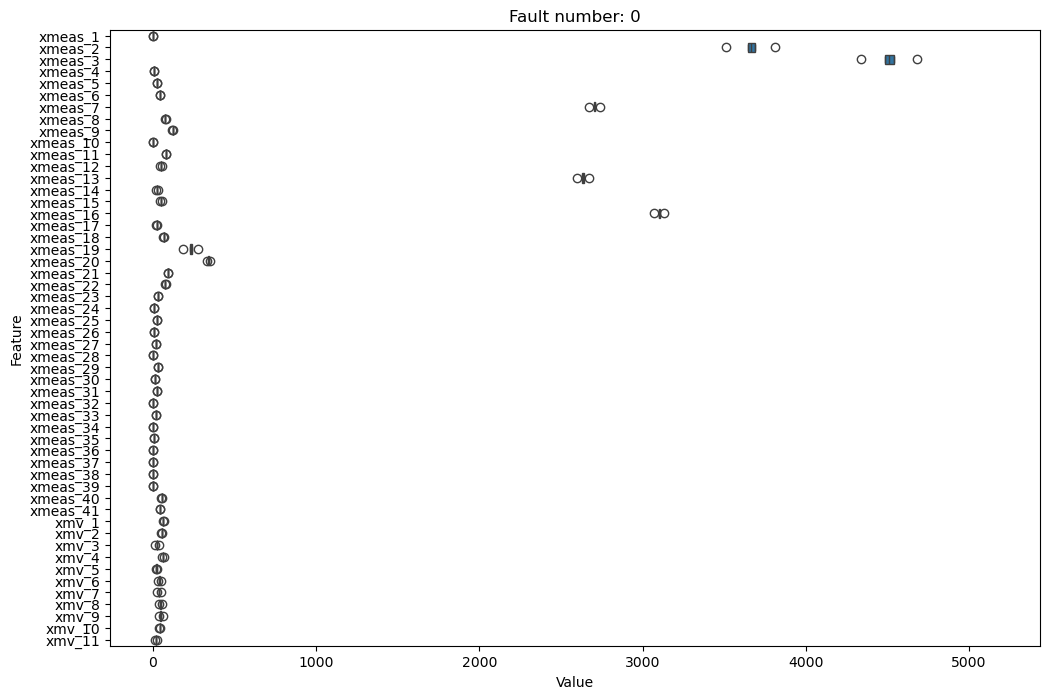

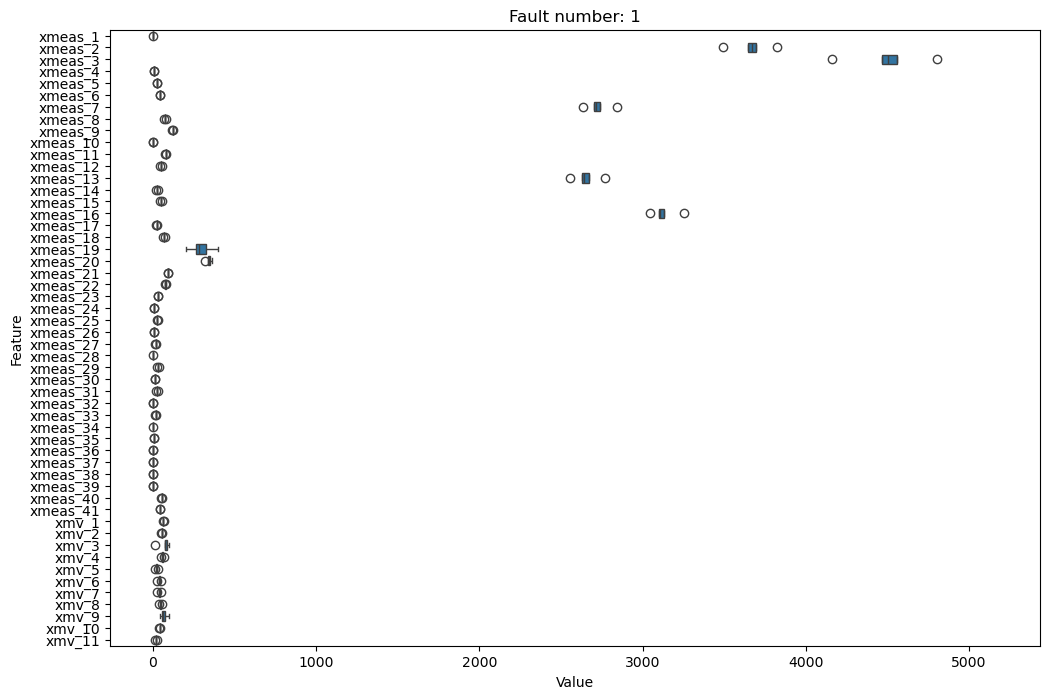

In [16]:
value_range = X_data_stats.loc['min'].min(), X_data_stats.loc['max'].max()
value_range_delta = value_range[1] - value_range[0]
value_range = value_range[0] - 0.05 * value_range_delta, value_range[1] + 0.05 * value_range_delta
for fault_number in range(2):
    mask = y_data == fault_number

    # Calculate the parameters needed for a boxplot
    boxplot_params = X_data[mask].describe().compute().T[['min', '25%', '50%', '75%', 'max']]

    # Prepare data for seaborn boxplot
    boxplot_data = []
    for feature in boxplot_params.index:
        feature_data = {
            'Feature': feature,
            'min': boxplot_params.loc[feature, 'min'],
            '25%': boxplot_params.loc[feature, '25%'],
            '50%': boxplot_params.loc[feature, '50%'],
            '75%': boxplot_params.loc[feature, '75%'],
            'max': boxplot_params.loc[feature, 'max']
        }
        boxplot_data.append(feature_data)

    boxplot_df = pd.DataFrame(boxplot_data)

    # Draw the boxplot using seaborn
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.boxplot(x='value', y='Feature', ax=ax, data=pd.melt(boxplot_df, id_vars='Feature', value_vars=['min', '25%', '50%', '75%', 'max']))
    ax.set_xlim(value_range)
    plt.title(f'Fault number: {fault_number}')
    plt.xlabel('Value')
    plt.ylabel('Feature')
    plt.show()

## Preprocessing

`StandardScaler` calculates the mean and standard deviation of each feature. This executes each task in the task graph that defines how to load the data. Each block of the data is processed individually. This works really well because there's equations for calculating the mean and standard deviation incrementally.

Calling the `transform` method of the scaler doesn't transform the data, it creates a task graph. The transform tasks are only processed just before they're needed.

In [9]:
scaler = Incremental(StandardScaler(), scoring='accuracy')
scaler.fit(X_data, y_data)

Incremental(estimator=StandardScaler(), scoring='accuracy')

In [10]:
X_norm = scaler.transform(X_data)

In [11]:
# X_norm is a task graph that results in a Dask array. IncrementalPCA needs to 
# know the chunk sizes of the Dask array, which are only really known by doing 
# some processing of the array.
X_norm.compute_chunk_sizes()

dask.array<_transform, shape=(5050000, 52), dtype=float64, chunksize=(5000, 52), chunktype=numpy.ndarray>

## Dimensionality reduction

We'll use PCA to reduce the dimensionality of the data as a second part of exploring the data. Standard Scikit-learn PCA loads the entire dataset into memory. Forunately, Dask-ml has an incremental PCA implementation. While slower and not as accurate as the standard PCA, it's more memory efficient.

In [20]:
pca = Incremental(IncrementalPCA(n_components=2), scoring='accuracy')
for epoch in range(10):
    X_norm_pca = pca.partial_fit(X_norm)
    print(f'Epoch {epoch + 1}: explained variance ratio = {np.sum(pca.explained_variance_ratio_)}')
X_norm_pca = pca.transform(X_norm)

Epoch 1: explained variance ratio = 0.4398077316403003
Epoch 2: explained variance ratio = 0.4398478959845566
Epoch 3: explained variance ratio = 0.4398620851289142
Epoch 4: explained variance ratio = 0.4398693395263684
Epoch 5: explained variance ratio = 0.4398737519015732
Epoch 6: explained variance ratio = 0.4398767362304732
Epoch 7: explained variance ratio = 0.439878882253533
Epoch 8: explained variance ratio = 0.43988050356379804
Epoch 9: explained variance ratio = 0.43988176914008525
Epoch 10: explained variance ratio = 0.4398827880221394


In [21]:
X_norm_pca.compute_chunk_sizes()
X_norm_pca.shape

(5050000, 2)

In [22]:
pca.explained_variance_ratio_

array([0.24720032, 0.19268246])

In [14]:
# Convert the Dask array resulting from incremental PCA to a Dask DataFrame
# for easier plotting.
X_norm_pca_df = ddf.from_dask_array(X_norm_pca, columns=['PC1', 'PC2'], index=X_data.index)
# Append the fault number so that we can colour the points in a scatter plot by fault number.
X_norm_pca_df['faultNumber'] = y_data

In [ ]:
# Plot the first two principal components of the data, coloured by fault number.
# The datashade=True argument is used to speed up plotting.
# DataShader is designed for large datasets. Instead of rendering each point, it
# aggregates the data into a grid and then renders the grid.
# If we tried hvplot.scatter without datashade=True, it would take a long time 
# to render (I'm not even sure it will finish, it didn't after 30 minutes).
X_norm_pca_df.hvplot.scatter(x='PC1', y='PC2', c='faultNumber', cmap='tab20', datashade=True)

:DynamicMap   []
   :RGB   [PC1,PC2]   (R,G,B,A)

### PCA discussion

PCA and plotting the two principal components doesn't reveal a lot, other than that all of the classes overlap.
There is one class has a unique shape to it's cluster (an arm sticking out to the right), but it's not clear if this is useful for classification.
The explained variance ratio is quite low, which suggests that more components are needed.
This becomes harder to visualise though.
The above code can be repeated for more components if desired.

### Kernel PCA

Kernel PCA is a non-linear version of PCA. It's useful for data that isn't linearly separable.
The code below shows how perform kernel PCA using Dask-ml.
Dask-ml provides `PolynomialFeatures` which one can use to create polynomial features for the kernel PCA.
`KernelPCA` in scikit-learn doesn't support the `partial_fit` method, so it can't be used with Dask's `Incremental` wrapper.
This will be a problem for keeping memory usage under control.

In [29]:
X_norm_poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(X_norm)
kpca = Incremental(IncrementalPCA(n_components=len(X_data.columns)), scoring='accuracy')
for epoch in range(10):
    X_norm_kpca = kpca.partial_fit(X_norm_poly)
    print(f'Epoch {epoch + 1}: explained variance ratio = {np.sum(kpca.explained_variance_ratio_)}')
X_norm_kpca = kpca.transform(X_norm_poly)

X_norm_kpca.compute_chunk_sizes()
X_norm_kpca.shape

/opt/conda/envs/ml/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/envs/ml/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
2025-01-07 18:55:57,539 - distributed.worker.memory - WARNING - gc.collect() took 1.749s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
ERROR:tornado.application:Uncaught exception GET /status/ws (10.88.0.1)
HTTPServerRequest(protocol='http', host='localhost:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='10.88.0.1')
Traceback (most recent call last):
  File "/opt/conda/envs/ml/lib/python3.9/si

Epoch 1: explained variance ratio = 0.918687190091844


2025-01-07 19:42:11,138 - distributed.worker.memory - WARNING - gc.collect() took 3.494s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 19:42:41,414 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 641.79 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 19:42:59,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 643.64 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 19:43:00,394 - distributed.worker.memory - WARNING

Epoch 2: explained variance ratio = 0.9188863257764951


2025-01-07 20:26:56,964 - distributed.worker.memory - WARNING - gc.collect() took 9.018s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 20:27:03,840 - distributed.worker.memory - WARNING - gc.collect() took 8.345s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 20:27:20,878 - distributed.worker.memory - WARNING - gc.collect() took 8.128s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 20:27:39,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 70

Epoch 3: explained variance ratio = 0.9189675719242634


2025-01-07 21:09:04,308 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 707.93 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 21:09:12,299 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:45785
Traceback (most recent call last):
  File "/opt/conda/envs/ml/lib/python3.9/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/opt/conda/envs/ml/lib/python3.9/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/envs/ml/li

Epoch 4: explained variance ratio = 0.9190139784755477


2025-01-07 21:49:11,658 - distributed.worker.memory - WARNING - gc.collect() took 1.201s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 21:49:57,927 - distributed.worker.memory - WARNING - gc.collect() took 10.080s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 21:50:01,005 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 645.76 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 21:50:01,876 - distributed.worker.memory - WARNING - gc.collect() took 4.433s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunki

Epoch 5: explained variance ratio = 0.9190447868034428


2025-01-07 22:30:45,440 - distributed.worker.memory - WARNING - gc.collect() took 1.370s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 22:31:59,233 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 623.56 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 22:32:07,534 - distributed.worker.memory - WARNING - gc.collect() took 8.810s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 22:32:09,492 - distributed.worker.memory - WARNING - gc.collect() took 4.838s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunkin

Epoch 6: explained variance ratio = 0.9190671219355915


2025-01-07 23:10:14,915 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 642.01 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 23:10:20,256 - distributed.worker.memory - WARNING - gc.collect() took 4.062s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 23:10:29,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 673.98 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 23:11:01,573 - distributed.worker.memory - WARNING

Epoch 7: explained variance ratio = 0.9190842656185395


2025-01-07 23:48:51,462 - distributed.worker.memory - WARNING - gc.collect() took 7.066s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 23:48:51,583 - distributed.worker.memory - WARNING - gc.collect() took 1.561s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-07 23:48:57,695 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 698.89 MiB -- Worker memory limit: 1.00 GiB
2025-01-07 23:49:12,156 - distributed.worker.memory - WARNING - gc.collect() took 2.800s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunkin

Epoch 8: explained variance ratio = 0.9190979665915024


2025-01-08 00:26:50,501 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 829.18 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 00:26:53,973 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 786.89 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 00:27:12,006 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 841.60 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 00:27:12,295 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 781.79 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 00:27:16,767 - distributed.worker.memory - WARNING - gc.collect() took 1.532s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-08 00:27:31,389 - distributed.worker.memory - WARNING - gc.collect() took 3

Epoch 9: explained variance ratio = 0.9191092493533117


2025-01-08 01:05:01,607 - distributed.worker.memory - WARNING - gc.collect() took 3.055s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-08 01:05:41,009 - distributed.worker.memory - WARNING - gc.collect() took 6.690s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-01-08 01:06:06,621 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 657.77 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 01:06:10,321 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 822.98 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 01:0

Epoch 10: explained variance ratio = 0.919118755957288


(5050000, 52)

In [30]:
# Convert the Dask array resulting from incremental PCA to a Dask DataFrame
# for easier plotting.
X_norm_kpca_df = ddf.from_dask_array(X_norm_kpca, columns=[f'PC{idx}' for idx in range(1, len(X_data.columns)+1, 1)], index=X_data.index)
# Append the fault number so that we can colour the points in a scatter plot by fault number.
X_norm_kpca_df['faultNumber'] = y_data
X_norm_kpca_df.hvplot.scatter(x='PC1', y='PC2', c='faultNumber', cmap='tab20', datashade=True)

2025-01-08 07:13:18,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 658.29 MiB -- Worker memory limit: 1.00 GiB


:DynamicMap   []
   :RGB   [PC1,PC2]   (R,G,B,A)

In [31]:
X_norm_kpca_df.hvplot.scatter(x='PC1', y='PC3', c='faultNumber', cmap='tab20', datashade=True)

2025-01-08 07:16:01,329 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 659.24 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 07:16:50,079 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 656.82 MiB -- Worker memory limit: 1.00 GiB


:DynamicMap   []
   :RGB   [PC1,PC3]   (R,G,B,A)

In [32]:
X_norm_kpca_df.hvplot.scatter(x='PC2', y='PC3', c='faultNumber', cmap='tab20', datashade=True)

2025-01-08 07:19:27,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 659.73 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 07:20:13,106 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 659.10 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 07:20:15,691 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

:DynamicMap   []
   :RGB   [PC2,PC3]   (R,G,B,A)

In [ ]:
hvplot.scatter_matrix(X_norm_kpca_df, c='faultNumber', cmap='tab20', datashade=True)

2025-01-08 19:07:30,324 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 618.44 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 19:07:31,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 615.56 MiB -- Worker memory limit: 1.00 GiB
2025-01-08 19:07:35,951 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

# Classification

This isn't particularly difficult, just wrap the Scikit-learn classifier in `dask_ml.wrappers.Incremental` and call either `fit` or `partial_fit`. **NB:** You need to pass the `classes` parameter to provide a list of the class labels that exist in `y_data`. Normally, if you call `fit` on a Scikit-learn classifier, Scikit-learn would determine this list by using the NumPy function `unique`. That isn't possible with `partial_fit` since there's no guarantee that all of the labels are present in the first batch of data.

`dask_ml.wrappers.Incremental` provides both `fit` and `partial_fit` methods. The difference is that `fit` overwrites the previous classifier, while `partial_fit` starts with the previous classifier and just keeps on calling that classifier's `partial_fit` method. Why care? Both methods iterate through the data once. But, you really want to present the data multiple times in different orders until converging to some notion of good performance. Both `fit` and `partial_fit` shuffle the order in which blocks are presented to the underlying classifier, resulting in the random order of the data.

One downside of `dask_ml.wrappers.Incremental` is that it only supports classifiers that have a `partial_fit` method, excluding most classifiers.

In [30]:
clf = Incremental(OneVsOneClassifier(SGDClassifier(loss='hinge', penalty='l2')), scoring='accuracy')
# clf = Incremental(OneVsOneClassifier(SGDClassifier(loss='log_loss', penalty='l1')), scoring='accuracy')
# clf = Incremental(OneVsOneClassifier(SGDClassifier(loss='squared_hinge', penalty='l2')), scoring='accuracy')
# clf = Incremental(MultinomialNB(), scoring='accuracy')

epochs = 10
epoch_scores = []
for epoch in range(epochs):
    clf.partial_fit(X_norm, y_data, classes=list(range(21)))
    epoch_score = clf.score(X_norm, y_data)
    epoch_scores.append(epoch_score)
    print(f'Epoch {epoch}: accuracy={epoch_score}')
# print(f'Train set accuracy={clf.score(X_norm, y_data)}')

Epoch 0: accuracy=0.47816257425742575
Epoch 1: accuracy=0.4889368316831683
Epoch 2: accuracy=0.48453247524752474
Epoch 3: accuracy=0.5075643564356436
Epoch 4: accuracy=0.49979623762376235
Epoch 5: accuracy=0.4996910891089109


2025-01-04 17:39:14,699 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:39:17,821 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:39:18,269 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:39:18,802 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:42:05,029 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:42:07,868 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:42:08,257 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 17:42:08,707 - distributed.utils_perf - WARNING - full garbage collections took

2025-01-04 17:46:00,739 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 619.78 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:46:00,892 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 623.83 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:46:00,934 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Epoch 6: accuracy=0.5091473267326733


2025-01-04 17:48:55,267 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 644.38 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:48:55,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 643.33 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:48:55,484 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Epoch 7: accuracy=0.4913059405940594


2025-01-04 17:51:44,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 670.72 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:51:45,128 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 666.11 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:51:45,790 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Epoch 8: accuracy=0.504599603960396


2025-01-04 17:54:38,826 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 685.98 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:54:38,846 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 688.88 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 17:54:39,465 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Epoch 9: accuracy=0.5049209900990099


Text(0.5, 1.0, 'Training accuracy')

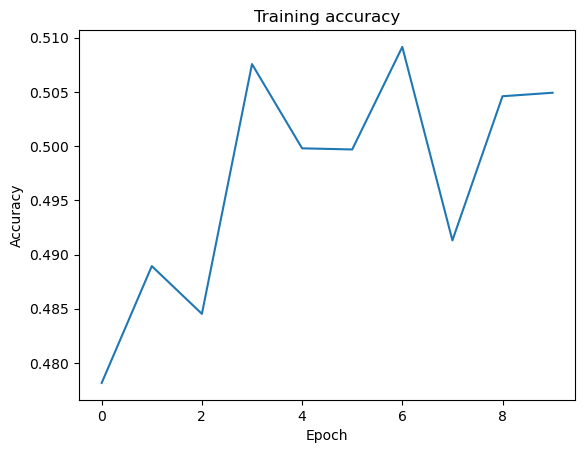

In [31]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(epoch_scores)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')

# Testing

First, load the data and apply the standard scaler to it. The time that this takes is just the time to build up the task graph, no processing happens here. Processing only happens when we call the `score` and `predict` methods of the classifier.

In [32]:
testing_data = ddf.read_hdf(test_data_path, key='/test_*')
X_data_test = testing_data.iloc[:, 3:]
y_data_test = testing_data.faultNumber
X_norm_test = scaler.transform(X_data_test)

2025-01-04 18:05:12,781 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [33]:
print(f'Test set accuracy: {clf.score(X_norm_test, y_data_test)}')

2025-01-04 18:06:12,749 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-01-04 18:06:21,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 714.97 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:06:21,681 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 722.61 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:06:21,688 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released 

Test set accuracy: 0.5124422169811321


In [34]:
y_pred_dask = clf.predict(X_norm_test)
y_pred = y_pred_dask.astype(np.int64).compute() # scikit-learn's f1_score and classification_report functions don't tolerate Dask arrays :(

2025-01-04 18:28:13,157 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 716.98 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:28:13,246 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 727.42 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:28:13,688 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2025-01-04 18:29:44,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 784.14 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:29:44,747 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 781.96 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:29:44,987 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [35]:
print(classification_report(y_data_test, y_pred))

2025-01-04 18:30:24,373 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 784.14 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:30:24,946 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 781.96 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:30:25,189 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    480000
           1       0.86      0.99      0.92    400000
           2       0.97      0.98      0.98    400000
           3       0.00      0.00      0.00    400000
           4       0.69      0.98      0.81    400000
           5       0.88      0.98      0.93    400000
           6       1.00      1.00      1.00    400000
           7       0.99      1.00      1.00    400000
           8       0.27      0.65      0.38    400000
           9       0.12      0.90      0.22    400000
          10       0.29      0.11      0.16    400000
          11       0.13      0.00      0.00    400000
          12       0.51      0.40      0.45    400000
          13       0.61      0.45      0.52    400000
          14       0.65      0.01      0.01    400000
          15       0.00      0.00      0.00    400000
          16       0.00      0.00      0.00    400000
          17       0.71    

2025-01-04 18:31:44,755 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 784.14 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:31:45,247 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 781.96 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:31:45,687 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

2025-01-04 18:32:04,775 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 784.14 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:32:05,348 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 781.91 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:32:05,700 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

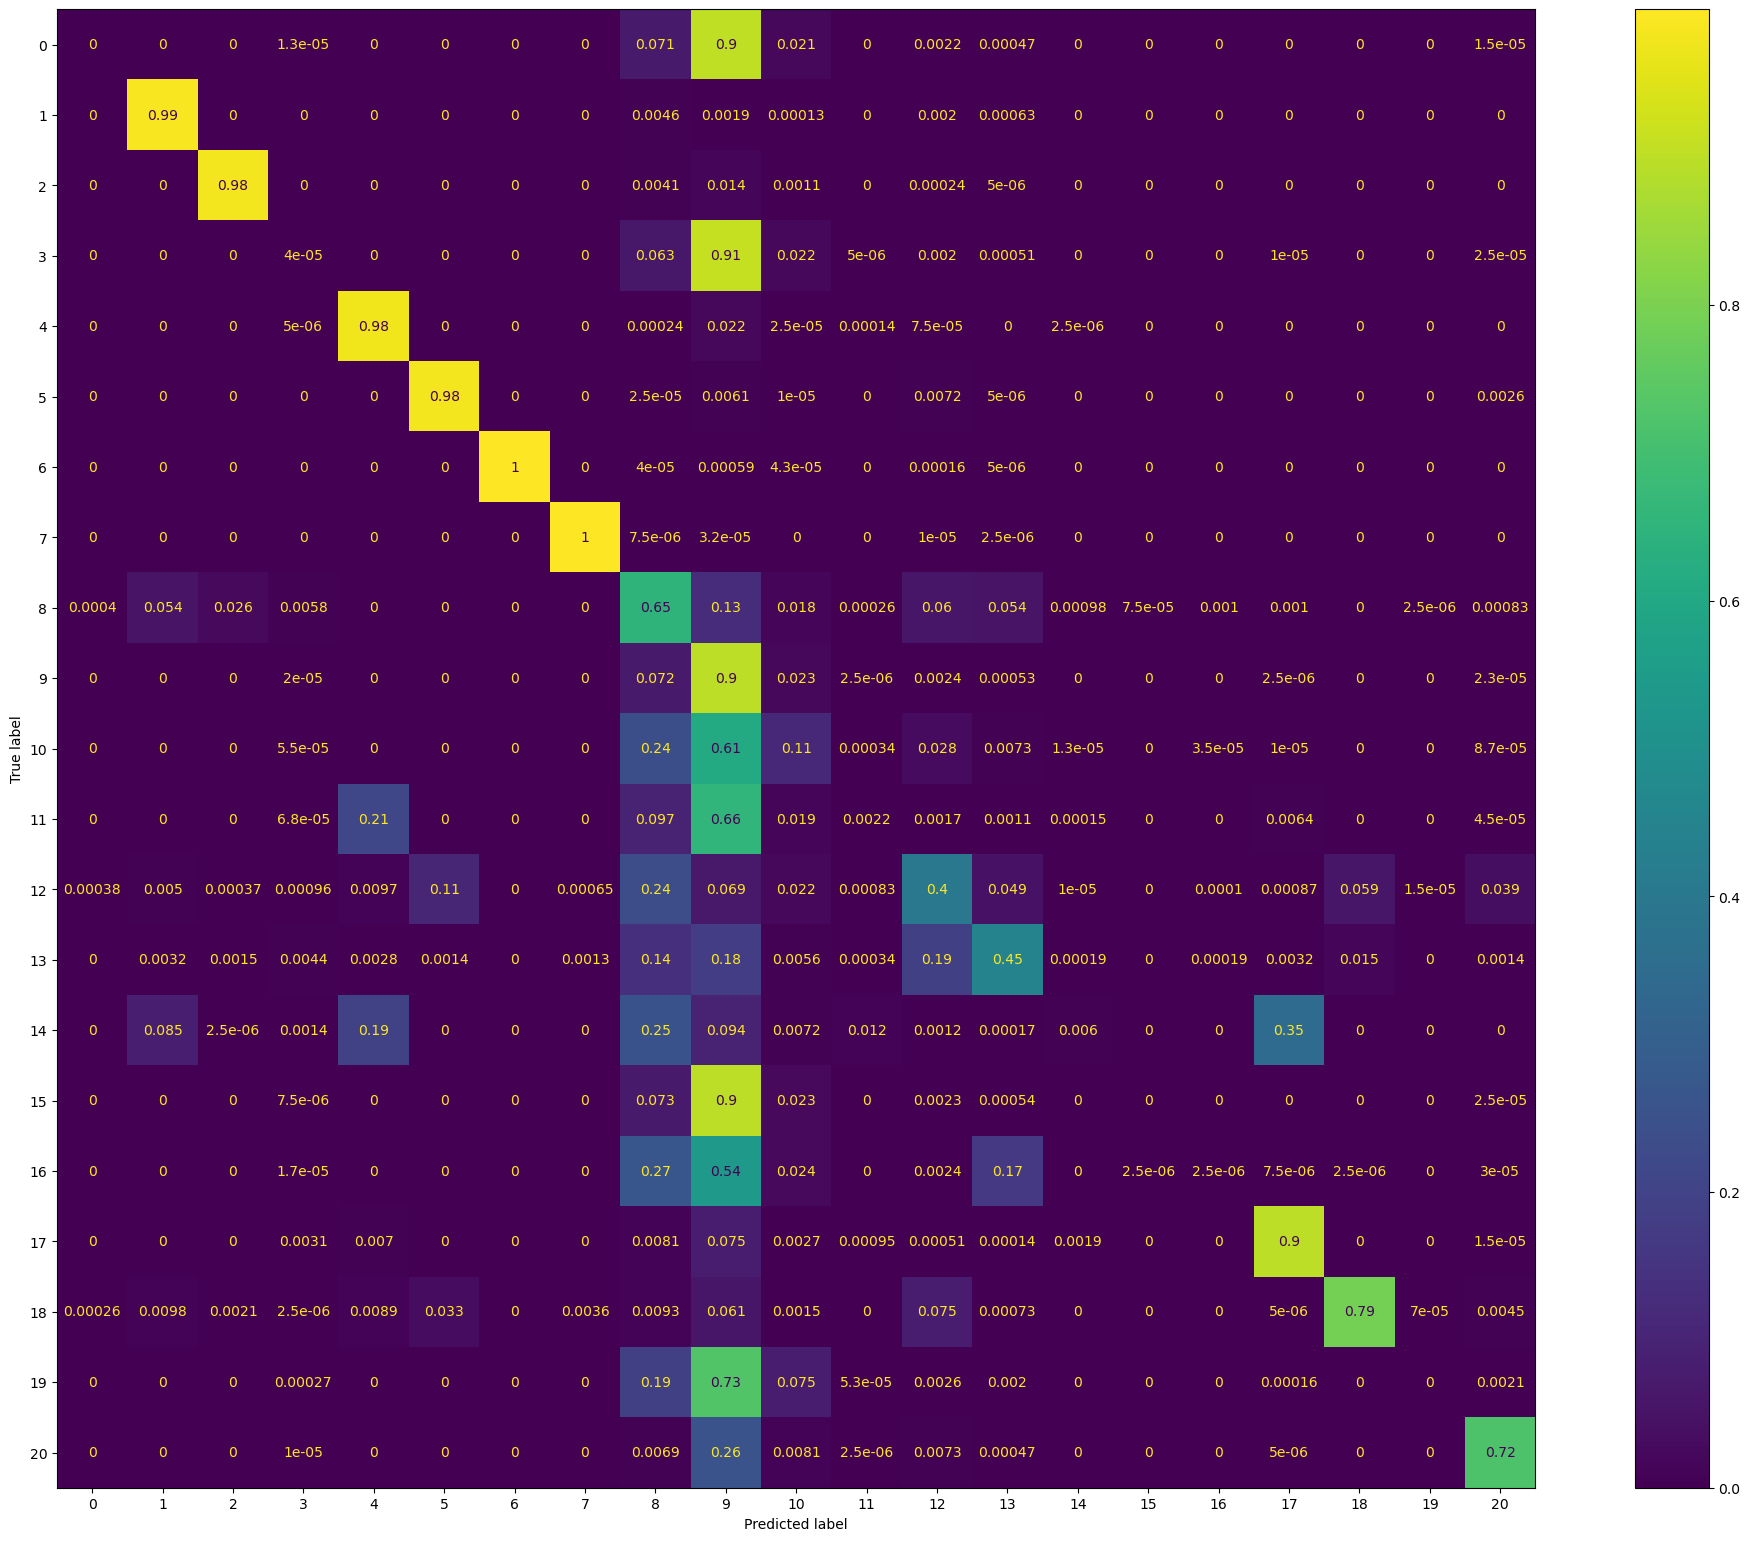

2025-01-04 18:34:25,455 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 784.14 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:34:26,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 781.96 MiB -- Worker memory limit: 1.00 GiB
2025-01-04 18:34:26,587 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [36]:
fig: plt.Figure = plt.figure(figsize=(6.4*4, 4.8*4))
ConfusionMatrixDisplay.from_predictions(y_data_test, y_pred, ax=fig.add_subplot(1, 1, 1), normalize='true')
plt.show()

In [14]:
dask_client.shutdown()
del dask_client